In [1]:
!cd C:\Users\User\OneDrive\Desktop\SelfStudy\segmentation1

In [2]:
#%pip install segmentation-models-pytorch

In [3]:
#%pip install -U git+https://github.com/albumentations-team/albumentations 
#%pip install --upgrade opencv-contrib-python

In [4]:
#!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

In [2]:
import sys 
sys.path.append('segmentation1\Human-Segmentation-Dataset-master')

In [3]:
from platform import python_version


print(python_version())

3.9.10


In [7]:
#%pip install torch

In [8]:
#%pip install opencv-contrib

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opencv-contrib (from versions: none)
ERROR: No matching distribution found for opencv-contrib
You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [9]:
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install sklearn
# %pip install tqdm
# %pip install helper==2.4.2

In [4]:
%pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import torch 
import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm 


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os 
print(os.getcwd())

c:\Users\User\OneDrive\Desktop\SelfStudy\segmentation1


In [7]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/segmentation1/'
DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
#ENCODER = 'time-efficientnet-b0'
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
row = df.iloc[9]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

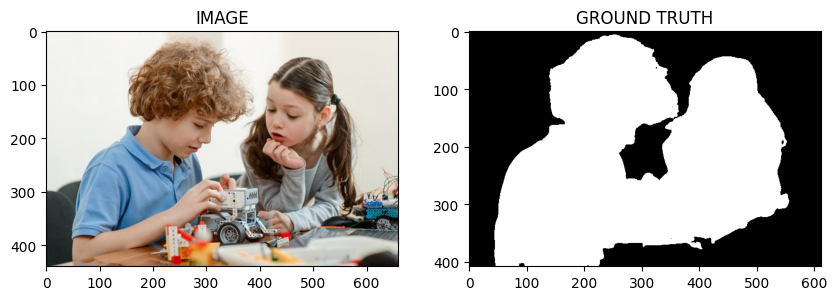

In [10]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
import albumentations as A

In [13]:

def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ])


In [14]:
from torch.utils.data import Dataset

In [16]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (320,320), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (320,320), interpolation=cv2.INTER_AREA)
        
        mask = np.expand_dims(mask, axis=-1)
        
        #print(f"image shape before transpose: {image.shape}")
        #print(f"mask shape before transpose : {mask.shape}")

        if self.augmentations:
            data = self.augmentations(image = image, mask=mask)
            image = data['image']
            mask = data['mask']
            
        # orginal (h, w, c) --> torch format (c, h, w)

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # convert numpy to tensor 
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        #print(f"image shape after transpose and convert to Torch: {image.shape}")
        #print(f"mask shape after transpose and convert to Torch: {mask.shape}")

        

        return image, mask

In [17]:
train_df['images']

6      Human-Segmentation-Dataset-master/Training_Ima...
209    Human-Segmentation-Dataset-master/Training_Ima...
223    Human-Segmentation-Dataset-master/Training_Ima...
261    Human-Segmentation-Dataset-master/Training_Ima...
73     Human-Segmentation-Dataset-master/Training_Ima...
                             ...                        
188    Human-Segmentation-Dataset-master/Training_Ima...
71     Human-Segmentation-Dataset-master/Training_Ima...
106    Human-Segmentation-Dataset-master/Training_Ima...
270    Human-Segmentation-Dataset-master/Training_Ima...
102    Human-Segmentation-Dataset-master/Training_Ima...
Name: images, Length: 232, dtype: object

In [18]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [19]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 232
Size of Validset: 58


In [20]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

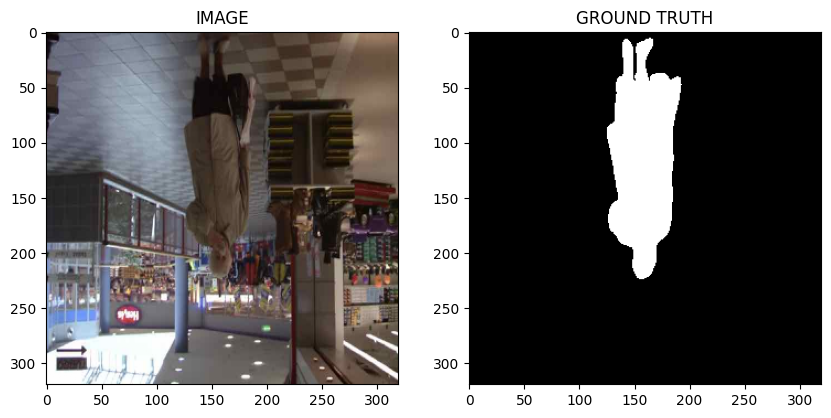

In [21]:
idx = 8
image, mask = trainset[idx]
show_image(image, mask)

In [22]:
from torch.utils.data import DataLoader

In [23]:
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = DataLoader(validset, batch_size=BATCH_SIZE)


In [24]:
print(f"total number of batches in trainloader", len(trainLoader))
print(f"total number of batches in validloader", len(validLoader))


total number of batches in trainloader 15
total number of batches in validloader 4


In [25]:
for image, mask in trainLoader:
    break 

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")


One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


segmentation_models_pytorch documentation: [(https://smp.readthedocs.io/en/latest/)]

In [26]:
from torch import nn 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [27]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name= ENCODER,
            encoder_weights= WEIGHTS,
            in_channels= 3,
            classes = 1,
            activation= None
        )

    def forward(self, images, masks = None):

        logits = self.arc(images)

        if masks != None: 
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [28]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

In [29]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss =+ loss.item()

    return total_loss / len(data_loader)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [31]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainLoader, model, optimizer)
    valid_loss = eval_fn(validLoader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('SAVED-MODEL')
        best_valid_loss = valid_loss

    print(f"Epoch : {i + 1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 0.7458361387252808 Valid Loss : 1.6198192834854126


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.3695095717906952 Valid Loss : 0.1411575973033905


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.2982830047607422 Valid Loss : 0.06855315715074539


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch : 4 Train Loss : 0.24927527010440825 Valid Loss : 0.1085333302617073


100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


Epoch : 5 Train Loss : 0.2489540656407674 Valid Loss : 0.08953849971294403


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED-MODEL
Epoch : 6 Train Loss : 0.19122119943300883 Valid Loss : 0.06663665920495987


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


SAVED-MODEL
Epoch : 7 Train Loss : 0.20248175462086995 Valid Loss : 0.049143336713314056


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch : 8 Train Loss : 0.19081466297308605 Valid Loss : 0.0782855749130249


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch : 9 Train Loss : 0.1782557725906372 Valid Loss : 0.09029562026262283


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 10 Train Loss : 0.2051313415169716 Valid Loss : 0.06463105976581573


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch : 11 Train Loss : 0.21450814803441365 Valid Loss : 0.0638929009437561


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 12 Train Loss : 0.19285558611154557 Valid Loss : 0.06847190856933594


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 13 Train Loss : 0.2036472092072169 Valid Loss : 0.10208553820848465


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


SAVED-MODEL
Epoch : 14 Train Loss : 0.16365294655164084 Valid Loss : 0.04842470958828926


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 15 Train Loss : 0.1402421087026596 Valid Loss : 0.0516444630920887


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 16 Train Loss : 0.17252576400836309 Valid Loss : 0.08688203990459442


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch : 17 Train Loss : 0.17884710530440012 Valid Loss : 0.07966793328523636


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch : 18 Train Loss : 0.14776143531004587 Valid Loss : 0.06620843708515167


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch : 19 Train Loss : 0.13687668691078822 Valid Loss : 0.07948658615350723


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 20 Train Loss : 0.1077198252081871 Valid Loss : 0.06790429353713989


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch : 21 Train Loss : 0.11118066807587941 Valid Loss : 0.048573192209005356


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


SAVED-MODEL
Epoch : 22 Train Loss : 0.12003337740898132 Valid Loss : 0.04340734705328941


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch : 23 Train Loss : 0.11044897685448328 Valid Loss : 0.09521327912807465


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 24 Train Loss : 0.09442930817604064 Valid Loss : 0.05525246262550354


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


SAVED-MODEL
Epoch : 25 Train Loss : 0.09441259205341339 Valid Loss : 0.040152400732040405


# inferencing 

In [36]:
idx = 20 
model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # C, H, W -> 1, C, H, W

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5 ) * 1.0 

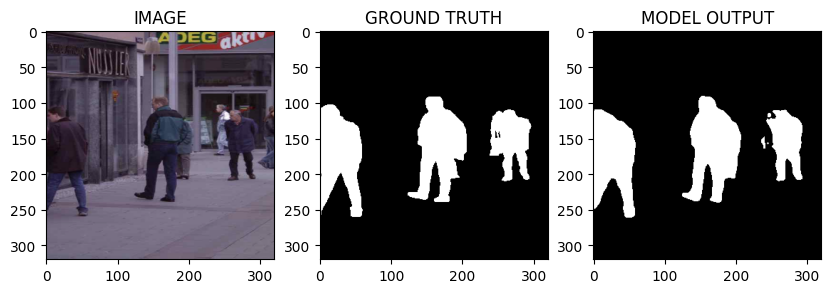

In [40]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))